In [27]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools

from tqdm import tqdm

In [28]:
from b2heavy.FnalHISQMetadata import params as mData

In [29]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [50]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
# DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24'
# DATA_2PT = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'
DATA_2PT = '/Users/pietro/Desktop/lattice24/0.25/corr3_1'


BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

JKFIT = True

In [51]:
# ENSEMBLE_LIST = ['MediumCoarse','Coarse-2','Coarse-1','Coarse-Phys','Fine-1','Fine-Phys','SuperFine']
ENSEMBLE_LIST = ['Coarse-2','Coarse-1','Coarse-Phys','Fine-1']
MOMLIST       = ['000','100','200','300','400']
RATIO_LIST    = ['xfstpar','RA1','ZRA1','XV','R0','R1']

In [95]:
Rs = []
jk = {}
for ens in ENSEMBLE_LIST:
    jk[ens] = {}
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}
        jk[ens][mom] = {}
        for rat in RATIO_LIST:
            try:
                res = read_config_fit(
                    tag  = f'fit3pt_config_{ens}_{rat}_{mom}',
                    path = DATA_2PT,
                    jk = JKFIT
                )
            except FileNotFoundError:
                continue

            f0 = res['ratio'][0] if JKFIT else res[-1]['ratio'][0]

            if JKFIT:
                jk[ens][mom][rat] = f0
                r = gv.gvar(f0.mean(),f0.std()*np.sqrt(len(f0)-1))
            else:
                r = f0

            if rat=='RA1':
                r = np.sqrt(r)
            elif rat=='ZRA1':
                r = np.sqrt(gv.gvar(-r.mean,r.sdev))
            
            if rat=='xfstpar':
                try:
                    aux['wrecoil'] = (1+r**2)/(1-r**2)
                except TypeError:
                    aux['wrecoil'] = None

                # if mom=='000':
                #     aux[rat] = gv.gvar('1(0)')
                #     aux['wrecoil'] = gv.gvar('1(0)')

            aux[rat] = r
        Rs.append(aux)

Rs = pd.DataFrame(Rs).set_index(['ensemble','mom'])

Rs = Rs.drop(('Coarse-1','400'))
Rs = Rs.drop(('Coarse-2','400'))

for ens in ENSEMBLE_LIST:
    Rs.loc[(ens,'000'),'wrecoil'] = gv.gvar('1(0)')

In [96]:
Rs

ZRA1      wrecoil      xfstpar         RA1          XV  \
ensemble    mom                                                                 
Coarse-2    000  0.9253(93)         1(0)          NaN         NaN         NaN   
            100         NaN   1.0242(19)  -0.1094(42)  0.8705(90)  0.2945(59)   
            200         NaN   1.0992(98)   -0.217(10)   0.811(23)   0.554(13)   
            300         NaN    1.156(26)   -0.269(21)   0.775(27)   0.723(26)   
Coarse-1    000   0.911(11)         1(0)          NaN         NaN         NaN   
            100         NaN   1.0124(29)  -0.0785(91)   0.954(22)  0.2217(53)   
            200         NaN    1.048(10)   -0.153(16)   0.912(25)  0.4292(87)   
            300         NaN    1.089(20)   -0.207(22)   0.905(28)   0.591(13)   
Coarse-Phys 000  0.9114(67)         1(0)          NaN         NaN         NaN   
            100         NaN  1.00537(69)  -0.0517(33)  0.9063(71)  0.1533(25)   
            200         NaN   1.0225(20)  -0.1055(47)   0.894(11)   0.315(11)   
            300         NaN   1.0500(38)  -0.1562(58)   0.864(28)   0.462(20)   
            400         NaN   1.0891(71)  -0.2066(79)   0.818(22)   0.623(28)   
Fine-1      000  0.9139(88)         1(0)          NaN         NaN         NaN   
            100         NaN   1.0134(24)  -0.0815(73)   0.914(17)  0.1898(23)   
            200         NaN   1.0422(35)  -0.1437(58)   0.888(12)  0.3769(28)   
            300         NaN   1.0874(62)  -0.2046(70)   0.845(21)  0.5457(47)   
            400         NaN    1.141(13)   -0.257(11)   0.851(26)    0.71(11)   

                          R0          R1  
ensemble    mom                           
Coarse-2    000          NaN         NaN  
            100  -0.1560(68)   1.070(27)  
            200   -0.338(11)   1.271(35)  
            300   -0.477(30)   1.395(43)  
Coarse-1    000          NaN         NaN  
            100  -0.1217(79)   1.055(12)  
            200   -0.244(45)   1.155(16)  
            300   -0.366(20)   1.290(27)  
Coarse-Phys 000          NaN         NaN  
            100  -0.0700(19)  1.0347(71)  
            200  -0.1496(32)  1.0758(92)  
            300  -0.2309(59)    1.16(17)  
            400  -0.3042(89)   1.193(23)  
Fine-1      000          NaN         NaN  
            100  -0.0940(38)  1.0095(83)  
            200  -0.1965(45)   1.094(49)  
            300   -0.309(41)   1.223(25)  
            400   -0.420(11)   1.391(49)

In [97]:
FF = []
for ens in ENSEMBLE_LIST:
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}

        if not (ens,mom) in Rs.index:
            continue

        w   = Rs['wrecoil'].loc[ens,mom]
        RA1 = Rs['RA1' if mom!='000' else 'ZRA1'].loc[ens,mom]
        XV  = Rs['XV'     ].loc[ens,mom]
        X0  = Rs['R0'     ].loc[ens,mom]
        X1  = Rs['R1'     ].loc[ens,mom]



        if w is None:
            continue

        aux['wrecoil'] = w
        aux['hA1']     = 2*RA1/(w+1)

        if mom=='000':
            aux['hA2'] = None
            aux['hA3'] = None
            aux['hV']  = None
        else:
            aux['hA2'] = 2*RA1/np.sqrt(w**2-1) * (w*X1 - np.sqrt(w**2-1)*X0-1)
            aux['hA3'] = 2*RA1/np.sqrt(w**2-1)(w-X1)
            aux['hV']  = 2*RA1/np.sqrt(w**2-1) * XV

        FF.append(aux)

FF = pd.DataFrame(FF).set_index(['ensemble','mom'])
FF

wrecoil         hA1        hA2        hA3         hV
ensemble    mom                                                          
Coarse-2    000         1(0)  0.9253(93)       None       None       None
            100   1.0242(19)  0.8601(89)   1.03(22)  8.064(83)   2.32(10)
            200   1.0992(98)   0.773(22)   1.96(15)   3.63(10)   1.97(12)
            300    1.156(26)   0.719(26)   2.38(17)  2.772(96)   1.93(20)
Coarse-1    000         1(0)   0.911(11)       None       None       None
            100   1.0124(29)   0.948(22)   1.06(16)  11.51(26)   2.68(33)
            200    1.048(10)   0.891(25)   1.67(15)   6.88(19)   2.50(28)
            300    1.089(20)   0.867(28)   2.36(17)   3.90(12)   2.48(31)
Coarse-Phys 000         1(0)  0.9114(67)       None       None       None
            100  1.00537(69)  0.9039(71)   0.83(13)  17.29(13)   2.68(18)
            200   1.0225(20)   0.884(10)  1.105(83)   8.60(10)   2.64(15)
            300   1.0500(38)   0.843(28)   1.57(95)   5.52(18)   2.49(17)
            400   1.0891(71)   0.783(22)   1.63(11)   4.02(11)   2.36(16)
Fine-1      000         1(0)  0.9139(88)       None       None       None
            100   1.0134(24)   0.908(16)  0.428(94)   9.70(18)   2.11(20)
            200   1.0422(35)   0.870(12)   1.20(31)  6.266(88)   2.28(10)
            300   1.0874(62)   0.810(20)   1.83(14)  3.797(94)  2.160(98)
            400    1.141(13)   0.795(25)   2.53(19)  3.075(95)   2.20(36)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


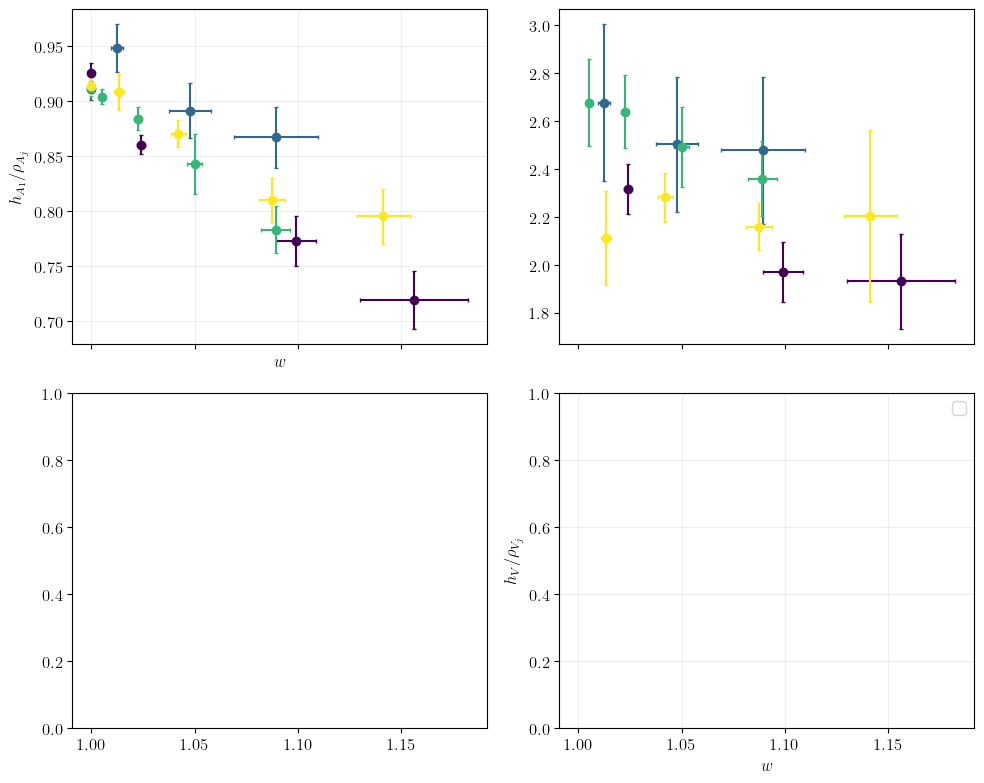

In [98]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

# f, ax = plt.subplots(2,2,figsize=(10,8),sharex=True)
f, ax = plt.subplots(2,2,figsize=(10,8),sharex=True)


color = plt.cm.viridis(np.linspace(0,1,len(ENSEMBLE_LIST)))

for i,ens in enumerate(ENSEMBLE_LIST):
    ax[0,0].errorbar(
        gv.mean(FF['wrecoil'].loc[ens].values),
        gv.mean(FF['hA1'].loc[ens].values),
        xerr = gv.sdev(FF['wrecoil'].loc[ens].values),
        yerr = gv.sdev(FF['hA1'].loc[ens].values),
        fmt     = 'o',
        ecolor  = color[i],
        # mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    dfy = FF['hV'].loc[ens].dropna()
    mask = FF.loc[ens].index.isin(dfy.index)
    dfx = FF['wrecoil'].loc[ens][mask]
    ax[0,1].errorbar(
        gv.mean(dfx.values),
        gv.mean(dfy.values),
        xerr = gv.sdev(dfx.values),
        yerr = gv.sdev(dfy.values),
        fmt     = 'o',
        ecolor  = color[i],
        # mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )


    # dfy = FF['hA2'].loc[ens].dropna()
    # mask = FF.loc[ens].index.isin(dfy.index)
    # dfx = FF['wrecoil'].loc[ens][mask]
    # ax[0,1].errorbar(
    #     gv.mean(dfx.values),
    #     gv.mean(dfy.values),
    #     xerr = gv.sdev(dfx.values),
    #     yerr = gv.sdev(dfy.values),
    #     fmt     = 'o',
    #     ecolor  = color[i],
    #     # mfc     = 'w', 
    #     color   = color[i], 
    #     capsize = 1.5,
    #     label   = ens
    # )

    # dfy = FF['hA3'].loc[ens].dropna()
    # mask = FF.loc[ens].index.isin(dfy.index)
    # dfx = FF['wrecoil'].loc[ens][mask]
    # ax[1,0].errorbar(
    #     gv.mean(dfx.values),
    #     gv.mean(dfy.values),
    #     xerr = gv.sdev(dfx.values),
    #     yerr = gv.sdev(dfy.values),
    #     fmt     = 'o',
    #     ecolor  = color[i],
    #     # mfc     = 'w', 
    #     color   = color[i], 
    #     capsize = 1.5,
    #     label   = ens
    # )


    # ax.errorbar(xin+off,gv.mean(yin),gv.sdev(yin),fmt=mrk[i%2], ecolor=color, mfc='w', color=color, capsize=2.5,alpha=alpha)

ax[0,0].set_ylabel(r'$h_{A_1}/\rho_{A_j}$')
ax[0,0].set_xlabel(r'$w$')
ax[0,0].grid(alpha=0.2)

ax[1,1].legend()
ax[1,1].set_ylabel(r'$h_V/\rho_{V_j}$')
ax[1,1].set_xlabel(r'$w$')
ax[1,1].grid(alpha=0.2)

plt.tight_layout()
plt.savefig(f'/Users/pietro/Desktop/ff.pdf')
